# Higgs Boson - ML Challenge

In [94]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from implementation import *
from model_helpers import *
from data_helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the dataset

In [11]:
paths = { 
    'train' : 'data/train.csv',
     'test' : 'data/test.csv',
     'submission' : 'data/sample-submission.csv'
        }
N = 4

y_tr, tx_tr, ids_tr = load_csv_data(paths['train'], sub_sample=False)
y_te, tx_te, ids_te = load_csv_data(paths['test'])

In [12]:
len_test = len(y_te)

y_tr = y_tr[:, np.newaxis]
y_pred = np.zeros(len_test)

## Divide into 4 different subsets depending on jet value

In [13]:
mask_tr = get_mask(tx_tr)
mask_te = get_mask(tx_te)

x_tr_subsamples = []
y_tr_subsamples = []

x_te_subsamples = []

for i in range(N):
    x_tr_subsamples.append(tx_tr[mask_tr[i]])
    y_tr_subsamples.append(y_tr[mask_tr[i]])
    x_te_subsamples.append(tx_te[mask_te[i]])

## Process the dataset

In [14]:
for j in range(N):
    x_tr_subsamples[j], x_te_subsamples[j] = pre_processing(x_tr_subsamples[j], x_te_subsamples[j], j)

C:\Users\Matteo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Matteo\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Cross Validation

In [27]:
def cross_validation(y, x, k_indices, k, lambda_, degree, function, max_iters=500):
    """
    Return the loss of ridge regression for a fold corresponding to k_indices
    
    Args:
        y:          shape=(N, 1)
        x:          shape=(N, D)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold
        lambda_:    scalar, used by ridge regression
        degree:     scalar, used by build poly
        gamma:      scalar, stepsize

    Returns:
        test loss: probability of predicting correct values
    """
    
    train_id = np.delete(k_indices, k, axis=0).ravel()
    test_id = k_indices[k]
    
    x_tr, y_tr = x[train_id], y[train_id]
    x_te, y_te = x[test_id], y[test_id]
    
    x_tr, x_te = build_poly(x_tr, degree), build_poly(x_te, degree)
    
    initial_w = np.zeros((x_tr.shape[1], 1))
    
    
    if function == 'RidgeRegression':
        
        w, _ = ridge_regression(y_tr, x_tr, lambda_)

    elif function == 'LeastSquares':
        
        w, _ = least_squares(y_tr, x_tr)
        
    elif function == 'LogisticRegression':
        
        w, _ = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
        
    elif function == 'RegLogisticRegression':
        
        w, _ = reg_logistic_regression(y_tr, x_tr, lambda_, initial_w, max_iters, gamma)
    
    
    return (y_te == predict_labels(x_te, w)).mean()

In [50]:
def cross_validation_grid_search(txs, ys, func):
    """
    Runs cross validation on the data with different values of hyperparameters to compare accuracy
    
    Args:
        txs: subsets of train dataset
        ys:  labels of the different subsets
        func: string, types of function
        
    """
    # Hyperparameters
    k_fold = 4
    seed = 100
    
    # Lambda: regularization parameter
    lambdas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    
    # Degree: feature augmentation
    degrees = range(1, 11, 1)
    
    # Gamma: stepsize
    #gammas = [] # [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    
    # split data in k fold
    k_indices = []
    for i in range(len(txs)):
        k_indices.append(build_k_indices(ys[i].shape[0], k_fold, seed))
        
    print(f"Function: {func}")
        
    best_tuple = [(-1, -1, -1)]*N
    
    # cross validation
    total_acc = np.array([0]*N)
    
    lambdas_acc = {}
    degrees_acc = {}
    
    for i in range(len(txs)):
        
        lambdas_acc[i] = [0]*len(lambdas)
        
        max_acc = 0
        print(f"->Subset {i}:")
        
        for l_i, l in enumerate(lambdas):
            
            max_local = 0
            
            for d in degrees:
                    
                pred_pcts = []
                
                for k in range(k_fold):
                    pred_pct = cross_validation(ys[i], txs[i], k_indices[i], k, l, d, func)
                    pred_pcts.append(pred_pct)

                pct = np.mean(pred_pcts)
                
                if pct > max_local:
                    max_local = pct
                    lambdas_acc[i][l_i] = pct
                
                if pct > max_acc:
                    max_acc = pct
                    best_tuple[i] = (l,d,pct)
                    print(f"- Set {i}/lamdba={l}/deg={d}/ACC={np.around(pct, 3)}")
                        
        
        total_acc[i] = max_acc
        
    mean_acc = np.mean(total_acc)
    
    print(f'Final mean accuracy: {mean_acc}')
    
    return best_tuple, lambdas_acc, degrees_acc

In [51]:
functions = ['RidgeRegression', 'LeastSquares', 'RegLogisticRegression']

best_tuple = {}

for func in functions[:-2]:
    best_tuple[func], lambdas, degrees = cross_validation_grid_search(x_tr_subsamples,y_tr_subsamples,func)

Function: RidgeRegression
->Subset 0:
- Set 0/lamdba=1e-09/deg=1/ACC=0.823
- Set 0/lamdba=1e-09/deg=2/ACC=0.836
- Set 0/lamdba=1e-09/deg=3/ACC=0.841
- Set 0/lamdba=1e-09/deg=4/ACC=0.841
- Set 0/lamdba=1e-09/deg=5/ACC=0.843
- Set 0/lamdba=1e-09/deg=6/ACC=0.844
- Set 0/lamdba=1e-09/deg=7/ACC=0.844
- Set 0/lamdba=1e-08/deg=7/ACC=0.844
- Set 0/lamdba=1e-07/deg=7/ACC=0.844
->Subset 1:
- Set 1/lamdba=1e-09/deg=1/ACC=0.739
- Set 1/lamdba=1e-09/deg=2/ACC=0.783
- Set 1/lamdba=1e-09/deg=3/ACC=0.802
- Set 1/lamdba=1e-09/deg=4/ACC=0.805
- Set 1/lamdba=1e-09/deg=5/ACC=0.807
- Set 1/lamdba=1e-09/deg=6/ACC=0.807
- Set 1/lamdba=1e-09/deg=7/ACC=0.808
- Set 1/lamdba=1e-05/deg=7/ACC=0.808
- Set 1/lamdba=1e-05/deg=10/ACC=0.808
- Set 1/lamdba=0.0001/deg=7/ACC=0.808
- Set 1/lamdba=0.0001/deg=9/ACC=0.808
- Set 1/lamdba=0.0001/deg=10/ACC=0.808
->Subset 2:
- Set 2/lamdba=1e-09/deg=1/ACC=0.759
- Set 2/lamdba=1e-09/deg=2/ACC=0.819
- Set 2/lamdba=1e-09/deg=3/ACC=0.831
- Set 2/lamdba=1e-09/deg=4/ACC=0.833
- Set 2/

In [52]:
lambdas

{0: [0.8437525022019376,
  0.8437625110096885,
  0.8437725198174393,
  0.8437625110096885,
  0.8437224757786852,
  0.843732484586436,
  0.8435323084314196,
  0.8418508287292817,
  0.8318119945552086],
 1: [0.8079541937480655,
  0.8079412978438049,
  0.8079541937480655,
  0.8079412978438048,
  0.8080057773651088,
  0.8083152790673682,
  0.808057360982152,
  0.8038532961931291,
  0.7824074074074074],
 2: [0.8345045259647451,
  0.8345045259647451,
  0.8345045259647451,
  0.8344846752421787,
  0.8344251230744799,
  0.8342861680165158,
  0.8338891535651898,
  0.8316063204700651,
  0.8127481340320788],
 3: [0.8389279913373038,
  0.8389279913373038,
  0.8389279913373038,
  0.8389279913373038,
  0.8389279913373038,
  0.838747518498466,
  0.8392889370149792,
  0.8378451543042772,
  0.81109005594658]}

In [58]:
l0 = np.array(lambdas[0])
l1 = np.array(lambdas[1])
l2 = np.array(lambdas[2])
l3 = np.array(lambdas[3])

ll = np.vstack((l0,l1,l2,l3))
np.mean(ll, axis=0)

array([0.8312848 , 0.83128408, 0.83128981, 0.83127912, 0.83127034,
       0.83127036, 0.83119194, 0.8287889 , 0.8095144 ])

In [99]:
# load package
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

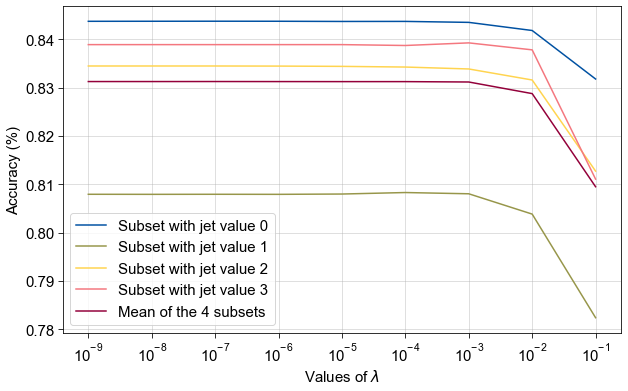

In [105]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']
params = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

ax.set_xscale('log')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel(r'Values of $\lambda$')

ax.plot(params, l0, color=colors[0], label='Subset with jet value 0')
ax.plot(params, l1, color=colors[1], label='Subset with jet value 1')
ax.plot(params, l2, color=colors[2], label='Subset with jet value 2')
ax.plot(params, l3, color=colors[3], label='Subset with jet value 3')
ax.plot(params, np.mean(ll, axis=0), color=colors[4], label='Mean of the 4 subsets')

major_ticks = params
minor_ticks = np.arange(0, 1e-1, 1000)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.legend(loc=0, prop={'size': 15})

fig.savefig('./report/lambdas.png', bbox_inches='tight')

## Train the model with the best parameters

In [45]:
def train_model(txs, ys, params):
    """Trains the classifier model
    
    Args:
        txs: training data split into three subsets
        y: labels of training data split into three subsets
    
    Returns:
        ws: weights of each subsets.
    """
    
    ws = []
    
    for i in range(len(txs)):
        
        lambda_, degree, gamma, _ = params[i]
        x_poly = build_poly(txs[i], degree)
        initial_w = np.zeros((x_poly.shape[1], 1))
        
        ws.append(ridge_regression(ys[i], x_poly, lambda_=lambda_)[0])
        
    return ws

In [46]:
chosen_function = 'RidgeRegression'

ws = train_model(x_tr_subsamples, y_tr_subsamples, best_tuple[chosen_function])

## Generate submission

In [47]:
def generate_predictions(txs_te, ws, mask_test, y_pred, params):
    """Generate the predictions and save ouput
    
    Args:
        txs_te: subsets of test dataset
        ws: weights of the different subsets
    """
    
    for j in range(len(txs_te)):
        degree = params[j][1]
        y_pred[mask_test[j]] = [y[0] for y in predict_labels(build_poly(txs_te[j],degree), ws[j])]
            
    create_csv_submission(ids_te, y_pred, paths['submission'])

In [48]:
generate_predictions(x_te_subsamples, ws, mask_te, y_pred, best_tuple[chosen_function])